[[10]
 [10]
 [10]
 ..., 
 [ 9]
 [ 9]
 [ 9]]


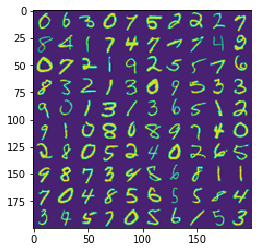

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.optimize import fmin_tnc
import random
import math

data = scipy.io.loadmat('ex4data1.mat')
Y_data = data["y"]

print(Y_data)

X = random.sample(list(data['X']),100)


def visualizeDigits(X):
    bigImg = np.zeros((200,200))
    
    xIndex = 0
    yIndex = 0
    
    for x in X:
        if xIndex == 200:
            yIndex += 20
            xIndex = 0
        img = np.reshape(x, (20,20)).T
        bigImg[xIndex:xIndex+20,yIndex:yIndex+20] = img
        xIndex += 20
    plt.imshow(bigImg)
    plt.show()
    return

visualizeDigits(X)

In [95]:
# transpose y so that it is a single row vector
# so it is better for "eye" matrix indexing
# also need to subtract one from every element in y

y_sub1 = np.vectorize(lambda x: x-1)(Y_data)
y_flip = y_sub1.T[0]

yMatrix = np.eye(10)[y_flip]
print(yMatrix)

[[ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 ..., 
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]]


In [100]:
# add bias column to X
X_data = np.insert(data["X"], 0, 1, axis=1)
print("X:\n", X_data, "\nShape: ", X_data.shape, "\n")

thetas = scipy.io.loadmat("ex4weights.mat")
theta1 = thetas["Theta1"]
theta2 = thetas["Theta2"]
print("theta1 shape: ", theta1.shape)
print("theta2 shape: ", theta2.shape)

def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

def feedForward(theta1, theta2, X):
    theta1 = np.matrix(theta1)
    theta2 = np.matrix(theta2)
    
    a1 = X
    
    z2 = a1 * theta1.T
    a2 = np.insert(sigmoid(z2), 0, 1, axis=1) # sigmoid and add bias column
    
    z3 = a2 * theta2.T # 5000x10 matrix
    a3 = sigmoid(z3)
    
    return {"a3": a3,
            "a2": a2,
            "a1": a1,
            "z2": z2,
            "z3": z3}

print("\na3:\n", feedForward(theta1,theta2,X_data)["a3"])


X:
 [[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]] 
Shape:  (5000, 401) 

theta1 shape:  (25, 401)
theta2 shape:  (10, 26)

a3:
 [[  1.12661530e-04   1.74127856e-03   2.52696959e-03 ...,   4.01468105e-04
    6.48072305e-03   9.95734012e-01]
 [  4.79026796e-04   2.41495958e-03   3.44755685e-03 ...,   2.39107046e-03
    1.97025086e-03   9.95696931e-01]
 [  8.85702310e-05   3.24266731e-03   2.55419797e-02 ...,   6.22892325e-02
    5.49803551e-03   9.28008397e-01]
 ..., 
 [  5.17641791e-02   3.81715020e-03   2.96297510e-02 ...,   2.15667361e-03
    6.49826950e-01   2.42384687e-05]
 [  8.30631310e-04   6.22003774e-04   3.14518512e-04 ...,   1.19366192e-02
    9.71410499e-01   2.06173648e-04]
 [  4.81465717e-05   4.58821829e-04   2.15146201e-05 ...,   5.73434571e-03
    6.96288990e-01   8.18576980e-02]]


In [101]:
theta1unroll = np.ravel(theta1) # unrolls theta1 to be a vector
theta2unroll = np.ravel(theta2)

input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10 # 10 labels, from 1 to 10

def nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                  num_labels, X, y, lamda):
    
    # extract theta1 and theta2
    theta1 = np.reshape(nn_params[:(input_layer_size + 1) * hidden_layer_size],
                        (hidden_layer_size, input_layer_size + 1))
    
    theta2 = np.reshape(nn_params[(input_layer_size + 1) * hidden_layer_size:],
                        (num_labels, hidden_layer_size + 1))
    
    # get a3, which is log(h_theta(x))
    a3 = np.matrix(feedForward(theta1,theta2,X)["a3"])
    y = np.matrix(y)
    m = X.shape[0]
    
    # there is a proof that for any matrix X,Y of size m by n,
    # sum of entry-wide products is equal to tr(X.T * Y)
    firstTerm = np.trace(-y.T * np.log(a3))
    secondTerm = np.trace((1-y.T) * np.log(1-a3))
    
    cost = (firstTerm - secondTerm)/m
    
    # for regularization, remove bias (first) column from each theta
    theta1_forReg = theta1[:,1:] # select all rows, select all columns from index 1 onwards
    theta2_forReg = theta2[:,1:]
    
    regTerm = (lamda / (2 * m)) * (np.sum(np.square(theta1_forReg)) + np.sum(np.square(theta2_forReg)))
    
    return cost + regTerm

costNoReg = nnCostFunction(nn_params,input_layer_size,hidden_layer_size,
                           num_labels, X_data, yMatrix, 0)
costWithReg = nnCostFunction(nn_params,input_layer_size,hidden_layer_size,
                     num_labels, X_data, yMatrix, 1)

print("No regularization: " + str(costNoReg))
print("Regularization parameter = 1: " + str(costWithReg))

No regularization: 0.287629165161
Regularization parameter = 1: 0.383769859091


In [102]:
def sigmoidGradient(z):
    firstTerm = 1 / (1 + np.exp(-z))
    secondTerm = 1 - firstTerm
    return np.multiply(firstTerm, secondTerm)

sigmoidGradient(0)

0.25

In [103]:
# randomly initialize weights to small values
epilson_init = 0.12
randTheta1 = np.random.rand(hidden_layer_size, 1 + input_layer_size) \
            * 2 * epilson_init - epilson_init
randTheta2 = np.random.rand(num_labels, 1 + hidden_layer_size) \
            * 2 * epilson_init - epilson_init
    
print(randTheta1.shape)
print(randTheta2.shape)

(25, 401)
(10, 26)


In [104]:
nn_params = np.concatenate((theta1unroll, theta2unroll),axis=0)
print(nn_params)

[ -2.25623899e-02  -1.05624163e-08   2.19414684e-09 ...,  -2.47795788e-01
   1.28009118e+00  -1.32752042e+00]


In [113]:
def nnCostFunctionWithBackProp(nn_params, input_layer_size, hidden_layer_size,
                               num_labels, X, y, lamda):
    '''
    First few lines are copy and pasted from nnCostFunction
    '''
    # extract theta1 and theta2
    theta1 = np.reshape(nn_params[:(input_layer_size + 1) * hidden_layer_size],
                        (hidden_layer_size, input_layer_size + 1))
    
    theta2 = np.reshape(nn_params[(input_layer_size + 1) * hidden_layer_size:],
                        (num_labels, hidden_layer_size + 1))
    
    # get a3, which is log(h_theta(x))
    feedForwardDict = feedForward(theta1,theta2,X)
    a3 = np.matrix(feedForwardDict["a3"])
    y = np.matrix(y)
    m = X.shape[0]
    
    d3 = a3 - y # 5000x10
    
    # remove bias column from theta2 to calculate d2
    theta2NoBias = theta2[:,1:] # 10x25
    z2 = np.matrix(feedForwardDict["z2"]) # 5000x25
    gPrime2 = sigmoidGradient(z2)
    d2 = np.multiply(d3*theta2NoBias,gPrime2) # 5000x25
    
    # calulating Deltas
    a1 = np.matrix(feedForwardDict["a1"]) # 5000x401
    Delta1 = d2.T * a1 # 10x5000
    
    a2 = np.matrix(feedForwardDict["a2"]) # 5000x26
    Delta2 = d3.T * a2 # 10x26
    
    Theta1_grad = Delta1 / m
    Theta2_grad = Delta2 / m
    
    return Theta1_grad, Theta2_grad

nnCostFunctionWithBackProp(nn_params,input_layer_size,hidden_layer_size,
                           num_labels, X_data, yMatrix, 0)

(matrix([[  6.18712766e-05,   0.00000000e+00,   0.00000000e+00, ...,
            9.70102410e-09,   2.85541159e-09,   0.00000000e+00],
         [  9.38798109e-05,   0.00000000e+00,   0.00000000e+00, ...,
            3.22774693e-08,  -1.26316319e-10,   0.00000000e+00],
         [ -1.92593606e-04,   0.00000000e+00,   0.00000000e+00, ...,
            7.05404498e-08,   1.41584916e-09,   0.00000000e+00],
         ..., 
         [  6.60569302e-05,   0.00000000e+00,   0.00000000e+00, ...,
           -1.40472252e-08,   1.94786057e-09,   0.00000000e+00],
         [  2.90522062e-04,   0.00000000e+00,   0.00000000e+00, ...,
            5.06149568e-07,  -5.54722494e-08,   0.00000000e+00],
         [ -6.33753316e-05,   0.00000000e+00,   0.00000000e+00, ...,
            5.05491848e-09,   4.46821993e-09,   0.00000000e+00]]),
 matrix([[  6.28737643e-04,   7.50946274e-04,   9.87964596e-05,
            1.48819864e-03,   7.31802078e-04,   1.38113760e-03,
           -1.59325422e-04,  -6.68870887e-04,  -1.2

In [93]:
np.shape(yMatrix)

(5000, 10)